<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/dune/Cypher_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# How Cypher changed in Neo4j v5

A couple of weeks ago, Neo4j 5 was released. If you are like me and have ignored all the deprecation warnings during the later Neo4j 4 version, you might have to update your Cypher queries to work with the latest Neo4j version. Luckily, there are no significant differences in the new Cypher syntax, so the update process should not be difficult. However, I have decided to write this blog post to help you transition. Additionally, I will introduce some of the new Cypher syntax that could simplify your queries.

## Neo4j environment setup
You will need to set up a Neo4j environment to follow the code examples in this post. As always, you can set up a local environment by using the Neo4j Desktop application. On the other hand, you can use a free cloud instance available as [Neo4j Aura](https://neo4j.com/cloud/platform/aura-graph-database/). If you choose the Neo4j Aura route, use the free forever instance and start a blank project that doesn't come with a pre-populated graph.



In [2]:
# Define Neo4j connections
import pandas as pd
from neo4j import GraphDatabase

host = 'neo4j+s://f4461036.databases.neo4j.io'
user = 'neo4j'
password = 'kdj8iDLIJomdKz3dNn7qUAx_6yeG7nbjIh7B6ZwIQVk'
driver = GraphDatabase.driver(host,auth=(user, password))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Dataset
I have a special place in my heart for fantasy or superhero datasets. This time, I found a dataset describing characters in the Dune series.

The [Dune dataset is available on Kaggle](https://www.kaggle.com/datasets/bac3917/frank-herberts-dune-characters) under the CC0 license. To make it easier for you, I have copied the dataset to a GitHub repository, so you don't have to download the dataset and can easily import it in either your local or cloud instance of Neo4j. Additionally, I have renamed the relationship types Parent-Child and Other Family to Family, and removed the Unknown relation.

## Graph Model

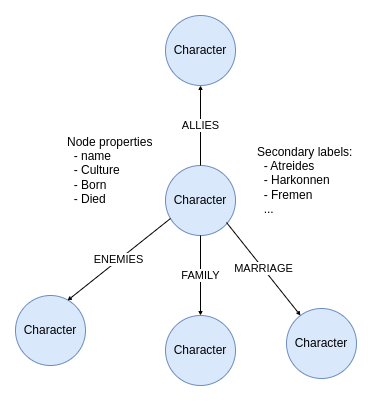

The graph model revolves around characters. The character nodes have multiple properties like the name, Culture, and when they were Born or Died. Additionally, their house allegiance is represented as a secondary node label. The main idea for using the secondary node label instead of a separate node is to demonstrate the new node label filtering options in Cypher. There are four types of relationships between characters: 

* ALLIES
* ENEMIES,
* FAMILY
* MARRIAGE

## Dataset import

As with most imports, you first want to define unique constraints in Neo4j. Unique constraints ensure that a given property is unique for every node with a particular label.
The syntax for defining unique constraints has slightly changed in Neo4j v5.

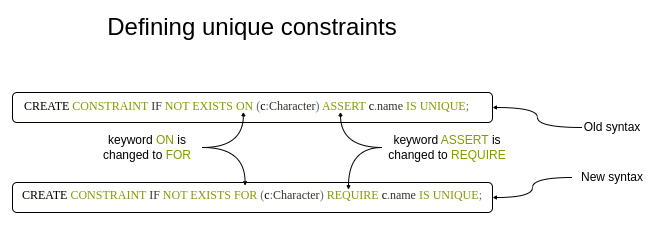

The new syntax for unique constraints has two keywords replaced. The *ON* keyword is replaced with *FOR*, while the *ASSERT* is changed to *REQUIRE*.

The following Cypher statements define the unique constraint for name property of Character nodes.

In [3]:
run_query("""
CREATE CONSTRAINT IF NOT EXISTS FOR (c:Character) REQUIRE c.name IS UNIQUE;
""")

""


Next, you need to import the CSV file. Even though the Dune CSV file has only 1000 rows, you will pretend you are dealing with a large CSV file with many thousands of rows. Therefore, you want to use batch import into multiple transactions. As **USING PERIODIC COMMIT** clause has been deprecated in Neo4j v5, you need to use the new batched transaction syntax.

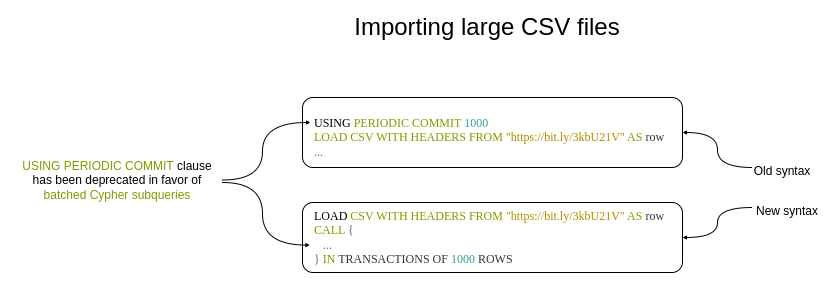

The subqueries were already introduced in Neo4j v4 but have taken on a more prominent role in v5. The subqueries are instantiated with a CALL clause and wrapped with curly brackets {}. They are great for various functionalities like post-union processing, limiting results per row, and conditional execution. Additionally, the Cypher subqueries are now the only native Cypher syntax (excluding APOC) to batch a single Cypher statement into multiple transactions. In order to specify that the Cypher subquery should be split into multiple transactions, you need to add **IN TRANSACTIONS OF x ROWS**, where the x represents the number of rows for each batch.

The following Cypher statement contains two nested subqueries. The top-level subquery is used to batch the import into a new transaction for every 10 rows. On the other hand, you use the nested  Cypher subquery as a conditional execution feature.

In [4]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3kbU21V" AS row
CALL {
  WITH row
  MERGE (c:Character {name:row.Character})
  SET c += apoc.map.clean(row, ["name", "Detail", "to", "relationship_type", "House_Allegiance"], [])
  WITH c, row
  CALL apoc.create.addLabels(c, [row.House_Allegiance]) YIELD node
  CALL {
    WITH row, c
    WITH row, c
    WHERE row.to IS NOT NULL
    MERGE (c1:Character {name: row.to})
    WITH row, c, c1
    CALL apoc.merge.relationship(c, toUpper(row.relationship_type), {}, {}, c1)
    YIELD rel
    RETURN count(*) AS count
  }
  RETURN count(*) AS finalCount
} IN TRANSACTIONS OF 10 ROWS
RETURN count(*)
""")

,count(*)
0,107


The import query is a bit more complicated because I wanted to do the import in a single Cypher statement. It starts with the **LOAD CSV** clause that you might have seen before. In order to batch the import into multiple transactions, you need to initiate a Cypher subquery with the **CALL** clause. The top-level subquery ends with the **IN TRANSACTIONS OF x ROWS** clause, which specifies the transaction batching.

If you want to use any variable in the Cypher statement, you must explicitly import it with the **WITH** clause. First, the top-level subquery import the row variable from the outer query. Next, it merges the Character node and sets a couple of properties. Since adding dynamic secondary labels is not supported in plain Cypher, you can use the APOC's procedure.
Some of the Dune characters have additional relationships defined in the **to** and **relationship_type** columns of the CSV. On the other hand, the to and relationship_type columns are empty for several rows. The **FOREACH** conditional execution trick was my go-to option for the better part of my blog post. However, as the theme of this blog post are Cypher subqueries, I have decided to show you how to use Cypher subqueries for conditional execution. First, with the nested Cypher subquery, you need to import both the **row** and the **c** variables. Next, you need to filter out only rows where the to column is not null. However, you cannot filter variables in the same **WITH** clause used to import them. Therefore, you need to add a second **WITH** clause to filter rows. Lastly, you use the APOC's procedure for merging relationships, as the plain Cypher syntax does not support creating properties with dynamic relationship types.

## New inline filtering options
There are many new options available for inline filtering in Neo4j v5. So what exactly is inline filtering? Essentially, it is the ability to filter a graph pattern directly in the **MATCH** clause.
You will begin by learning the new syntax for filtering node labels. In Neo4j v5, the following logical expressions were introduced to allow more flexible node filtering.

* & - AND expression
* | - OR expression
* ! - NOT expression

For example, if you want to match all nodes with either the Fremen or Harkonnen label, you can use the **|** expression.

In [5]:
run_query("""
MATCH (c:Fremen|Harkonnen)
RETURN count(*)
""")

,count(*)
0,16


On the other hand, if you need to find all nodes with both the Character and Harkonnen labels, you can use the & expression.

In [6]:
run_query("""
MATCH (c:Character&Harkonnen)
RETURN count(*)
""")

,count(*)
0,15


The ! expression allows you to negate node labels. For example, say that you want to match all nodes with the Character label but don't have the Harkonnen label.

In [7]:
run_query("""
MATCH (c:Character&!Harkonnen)
RETURN count(*)
""")

,count(*)
0,64


The Cypher now also supports nested expressions for filtering node labels. For example, the following Cypher statement matches all nodes that don't have the Fremen or the Harkonnen labels.

In [8]:
run_query("""
MATCH (c:!(Fremen|Harkonnen))
RETURN count(*)
""")

,count(*)
0,63


The expressions are nested using the parenthesis ().

Another feature added to Cypher is the option to include the **WHERE** clause within the **MATCH** clause. This allows you to apply all the flexibility of the Cypher filtering by node properties directly within the **MATCH** statement.

For example, the following Cypher statement matches all characters where the Culture property starts with Z and the Died property is not null.

In [9]:
run_query("""
MATCH (c:Character WHERE c.Culture STARTS WITH "Z" AND c.Died IS NOT NULL)
RETURN c.name AS character
""")

,character
0,Ali Ben Ohashi
1,Maometh


The same logical expressions used to filter nodes can also be used when filtering relationship types. For example, the | expression, which expresses the logical OR, has been in Cypher for quite some time.

The following Cypher statement matches all Character nodes with the Culture property values of Bene Gesserit and expands their **ALLIES** or **FAMILY** relationships.

In [10]:
run_query("""
MATCH p=(c:Character WHERE c.Culture = "Bene Gesserit")-[r:ALLIES|FAMILY]-()
RETURN [n in nodes(p) | n.name] AS pairs, type(r) AS results
""")

,pairs,results
0,"[Anirul Corrino, Shaddam Corrino IV]",FAMILY
1,"[Jessica Atreides, Paul Atreides]",FAMILY
2,"[Jessica Atreides, Paul Atreides]",FAMILY


Using only the & expression does not really make sense as a single relationship cannot have more than one type. However, the combined with the negation ! expression the & can come in handy.

For example, the following Cypher statement expands all relationships that are not **ALLIES** or **FAMILY**.

In [12]:
run_query("""
MATCH p=(c:Character WHERE c.Culture = "Fremen")-[r:!ALLIES&!FAMILY]-()
RETURN [n in nodes(p) | n.name] AS pairs, type(r) AS results
""")

,pairs,results
0,"[Chani Kynes, Paul Atreides]",MARRIAGE
1,"[Geoff, Jamis]",ENEMIES
2,"[Jamis, Geoff]",ENEMIES
3,"[Stilgar, Tharthar]",MARRIAGE
4,"[Liet Kynes, Uliet]",ENEMIES
5,"[Mitha, Pardot Kynes]",MARRIAGE


## Existential subqueries
Next, you will learn how the syntax for existential subqueries changed. An existential subquery can be used to find graph patterns that are part of a specified pattern.

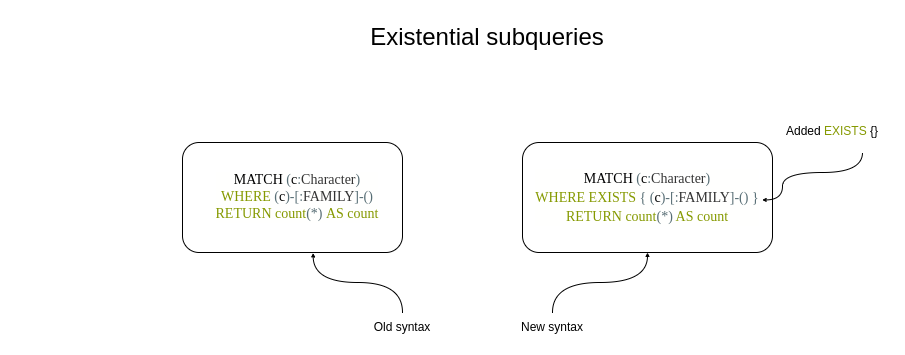

In this example, the existential subquery is used to find **Character** nodes that have either incoming or outgoing **FAMILY** relationships. I am a fan of existential subqueries as they offer the flexibility to filter nodes based on any graph patterns without having to expand them in the **MATCH** clause and worry about query cardinality (number of rows). In Neo4j v5, you have to add the **EXISTS** clause and wrap the specified graph pattern used for filtering with curly brackets in order to execute existential subqueries.

In [13]:
run_query("""
MATCH (c:Character)
WHERE exists { (c)-[:FAMILY]-() }
RETURN count(*) AS count
""")

,count
0,27


Additionally, you can now introduce new reference variables in the existential subqueries. For example, the following existential subquery filters Character nodes with a FAMILY relationship. However, only the patterns where the end node of the FAMILY relationship has both the ALLIES and the MARRIAGE relationship are considered.

In [14]:
run_query("""
MATCH (c:Character)
WHERE exists { (c)-[:FAMILY]-(t)
               WHERE (t)-[:ALLIES]-() AND (t)-[:MARRIAGE]-() }
RETURN count(*) AS count
""")

,count
0,5


You may also see examples of a MATCH clause used within the existential subquery. Based on my experience, the MATCH clause is entirely optional. However, it might make the existential subquery syntax more readable and intuitive.

In [15]:
run_query("""
MATCH (c:Character)
WHERE exists { MATCH (c)-[:FAMILY]-(t)
               WHERE (t)-[:ALLIES]-() AND (t)-[:MARRIAGE]-() }
RETURN count(*) AS count
""")

,count
0,5


## Count subqueries
The last category of subqueries in this post is the so-called count subqueries. They are used to count the number of defined graph patterns. For example, I frequently used them in my previous blog posts to count the number of relationships a node has.

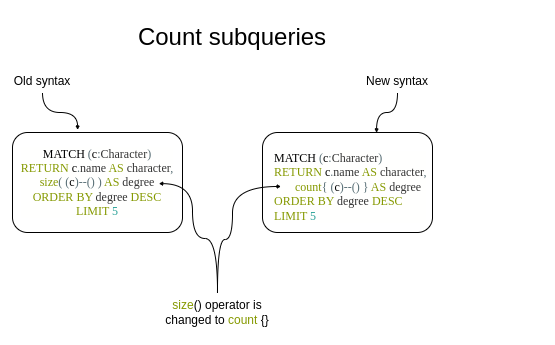

Previously, you could wrap a graph pattern with the size() in order to count the number of particular patterns. It is a handy syntax to count graph patterns without affecting the cardinality of the main query. Additionally, it might outperform other approaches to counting the number of relationships. In Neo4j v5, you need to replace the size() operator with the count{}.

The following Cypher statement returns the top five Character node ordered by their degree (relationship count).

In [16]:
run_query("""
MATCH (c:Character)
RETURN c.name AS character,
       count{ (c)--() } AS degree
ORDER BY degree DESC
LIMIT 5
""")

,character,degree
0,Paul Atreides,16
1,Leto Atreides I,15
2,Stilgar,7
3,Vladimir Harkonnen,6
4,Shaddam Corrino IV,6


As before, you can filter nodes by using the counting subqueries in a WHERE clause. In this example, the Cypher statement filters nodes with more than relationships.

In [17]:
run_query("""
MATCH (c:Character)
WHERE count{ (c)--() } > 2
RETURN count(*) AS count
""")

,count
0,11
